In [299]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier


import warnings
warnings.filterwarnings('ignore')

In [300]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [301]:
columns = ['PERMIT_ID', 'UNITS', 'NET_UNITS', 'BESTSTAT', 'YEAR', 'QUARTER', 'NAMEADDR']

def loadData():
    file_name = "data_complete/PipelineCleaned_"
    data = []
    for year in range(2014, 2018):
        for q in range(1, 5):
            if year == 2017 and q == 2:
                break
            X = pd.read_csv(file_name + str(year) + "_Q" + str(q) + ".csv", sep=',', infer_datetime_format=True)
            X["YEAR"] = year
            X["QUARTER"] = q
            data.append(X)
    df = pd.concat(data)
    return df

def loadPermits():
    converters = {'Permit Number': lambda x: 'N'+x.replace(',','')}
    permits = pd.read_csv("data_complete/Building_Permits_Filtered.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_STATUS_DATE'])
    permits = permits.drop_duplicates()
    permits = permits.set_index('PERMIT_ID')
    
    X = pd.read_csv("data_complete/Building_Permits_ISSUED.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_ISSUED_DATE'])
    X = X.drop_duplicates()
    X = X.set_index('PERMIT_ID')
    X.rename(columns = {'PERMIT_ISSUED_DATE':'PERMIT_DATE'}, inplace = True)
    return X, permits

permits, more_permits = loadPermits()
    
df = loadData()
df = df[columns]
df = df[df["BESTSTAT"] == "CONSTRUCTION"]
df.drop(["BESTSTAT"], inplace=True, axis=1)
df.head()
permits.count()

PERMIT_DATE    344941
dtype: int64

In [302]:
permits = permits.join(more_permits, how='inner')

# keep only first and last entry for each building
construction_start = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=['PERMIT_ID'], keep="first")
construction_end = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=['PERMIT_ID'], keep="last")

data = pd.merge(construction_start[['PERMIT_ID', 'YEAR', 'QUARTER']], construction_end, 
                how='inner', on=['PERMIT_ID'], left_on=None, right_on=None, suffixes=('_START', '_END'))

data = data[~data.duplicated('PERMIT_ID')]
data = data.set_index('PERMIT_ID')

print(len(data))
data = data.join(permits, how='inner')
print(len(data))

data['PERMIT_DATE_YEAR'] = pd.DatetimeIndex(data['PERMIT_DATE']).year
data['PERMIT_DATE_QUARTER'] = pd.DatetimeIndex(data['PERMIT_DATE']).quarter

# Duration = last 'construction' entry year/quarter - permit issue year/quarter in quarters
data['DURATION'] = (data['YEAR_END'] - data['PERMIT_DATE_YEAR']) * 4 + data['QUARTER_END'] - data['PERMIT_DATE_QUARTER'] + 1
data = data[['UNITS', 'NET_UNITS', 'YEAR_END', 'QUARTER_END', 'NAMEADDR',# , 'PERMIT_DATE', 'YEAR_START', 'QUARTER_START'
             'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION', 'COST', 'PERMIT_TYPE']]#, 'PERMIT_STATUS', 'PERMIT_STATUS_DATE']]
data['COST'] = data['COST'].fillna(data['COST'].mean()).astype('int64')
data.groupby(['PERMIT_TYPE']).count()

565
679


,UNITS,NET_UNITS,YEAR_END,QUARTER_END,NAMEADDR,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,COST
PERMIT_TYPE,,,,,,,,,
additions alterations or repairs,294,294,294,294,294,294,294,294,294
new construction,101,101,101,101,101,101,101,101,101
new construction wood frame,280,280,280,280,280,280,280,280,280
otc alterations permit,4,4,4,4,4,4,4,4,4


In [303]:
# Split completed by 2017Q1 and still in construction by 2017Q1
not_completed_ids = data[(data['YEAR_END'] == 2017)].index
complete = data[~data.index.isin(not_completed_ids)]
incomplete = data[data.index.isin(not_completed_ids)]

print("Completed by 2017: ", complete['NET_UNITS'].count())
print("Still in construction by 2017: ", incomplete['NET_UNITS'].count())

Completed by 2017:  464
Still in construction by 2017:  215


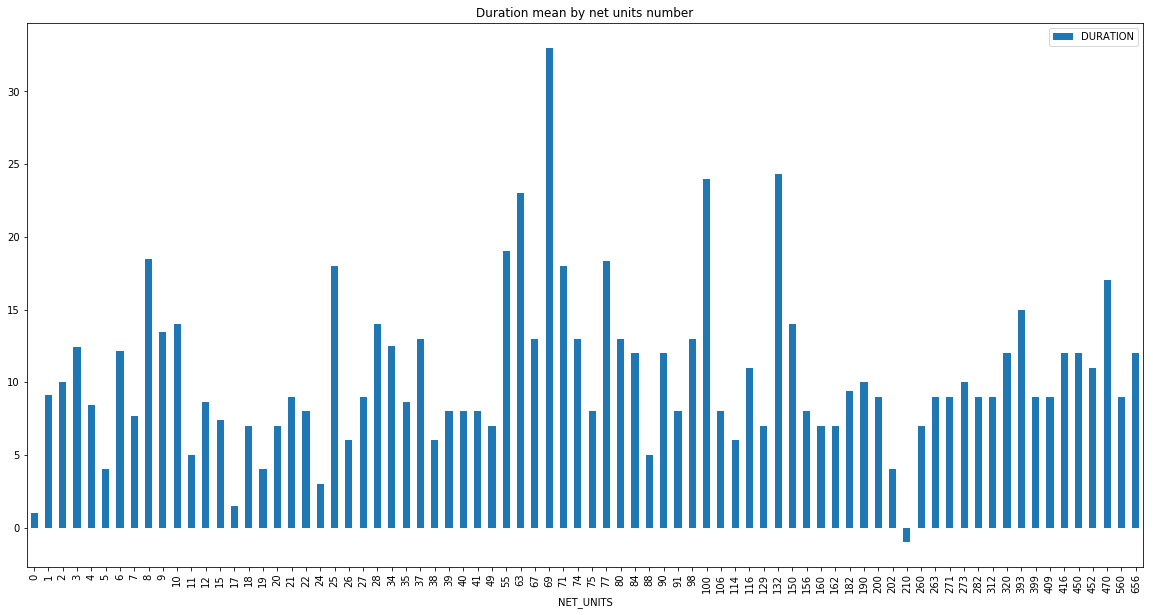

In [304]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['NET_UNITS']).mean()
grouped.plot(y = 'DURATION', kind = "bar", figsize=(20,10), title = "Duration mean by net units number")

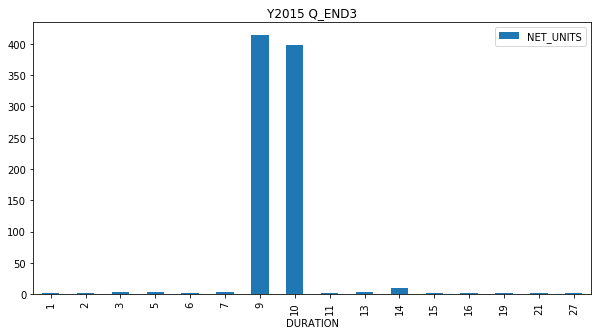

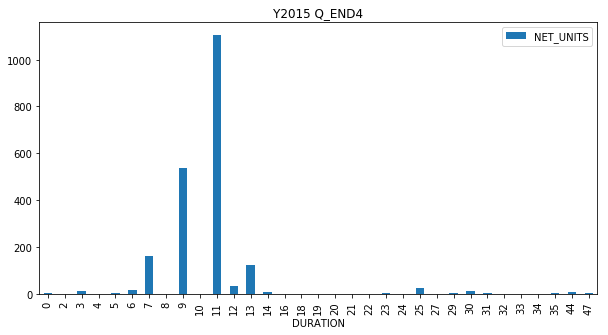

In [305]:
def plot_duration(year, quarter_end):
    d1 = complete[(complete['YEAR_END'] == year) & (complete['QUARTER_END'] == quarter_end)]
    grouped = d1.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
    grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(10,5), title = "Y" + str(year) + " Q_END" + str(quarter_end))

#plot_duration(2015, 1)
#plot_duration(2015, 2)
plot_duration(2015, 3)
plot_duration(2015, 4)

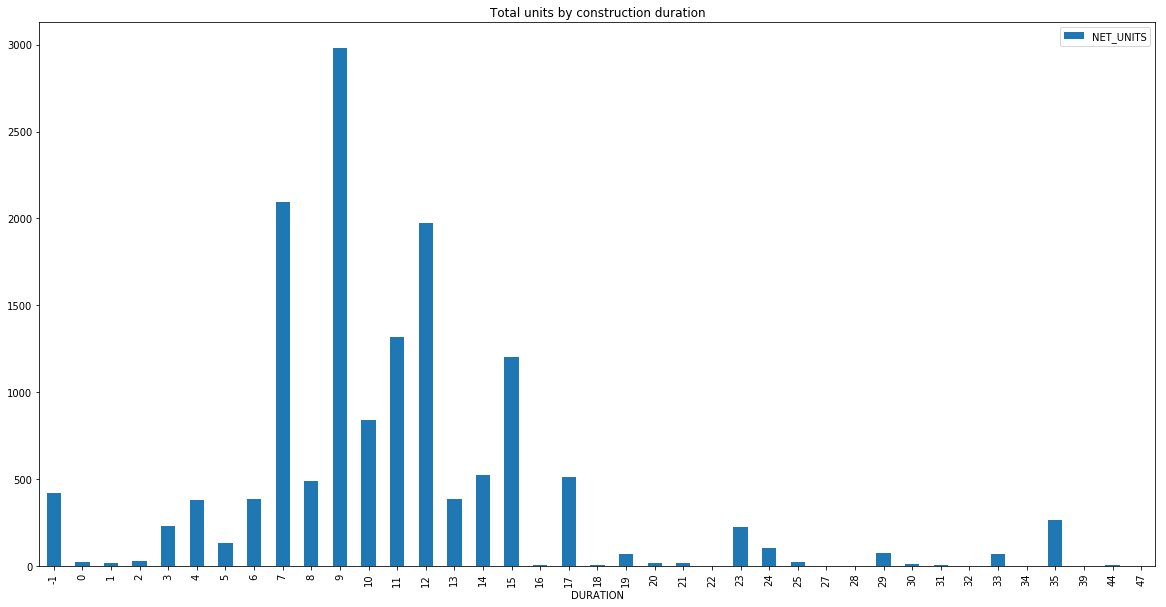

In [306]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Total units by construction duration")

In [307]:
def mean_std_norm(column):
    return (column - column.mean()) / column.std()

def min_max_norm(column):
    return (column - column.min())/(column.max() - column.min())

result = incomplete.copy()

complete['PERMIT_DATE_YEAR_NORM'] = mean_std_norm(complete['PERMIT_DATE_YEAR'])
incomplete['PERMIT_DATE_YEAR_NORM'] = mean_std_norm(incomplete['PERMIT_DATE_YEAR'])

complete['UNITS_NORM'] = mean_std_norm(complete['UNITS'])
incomplete['UNITS_NORM'] = mean_std_norm(incomplete['UNITS'])

complete['NET_UNITS_NORM'] = mean_std_norm(complete['NET_UNITS'])
incomplete['NET_UNITS_NORM'] = mean_std_norm(incomplete['NET_UNITS'])

complete['COST_NORM'] = mean_std_norm(complete['COST'])
incomplete['COST_NORM'] = mean_std_norm(incomplete['COST'])


columns_to_show = ['NAMEADDR', 'UNITS', 'NET_UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION', 'DURATION_PREDICTED', 
                   'YEAR_END', 'QUARTER_END' , 'YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED', 'COST']

In [308]:
display(permits.head())
permits = permits[(permits["PERMIT_TYPE"] == "new construction wood frame") | 
                  (permits["PERMIT_TYPE"] == "new construction") |
                  (permits["PERMIT_TYPE"] == "additions alterations or repairs")].reset_index()
permits = permits[(permits['PERMIT_STATUS'] == 'issued') & (permits['NET_UNITS_'] > 0) & (permits['NET_UNITS_'] < 800)]

permits['PERMIT_DATE_YEAR'] = pd.DatetimeIndex(permits['PERMIT_DATE']).year
permits['PERMIT_DATE_QUARTER'] = pd.DatetimeIndex(permits['PERMIT_DATE']).quarter

permits['PERMIT_DATE_YEAR_NORM'] = mean_std_norm(permits['PERMIT_DATE_YEAR'])

permits['UNITS_NORM'] = mean_std_norm(permits['UNITS_'])

permits['NET_UNITS_NORM'] = mean_std_norm(permits['NET_UNITS_'])

permits['COST'] = permits['COST'].fillna(permits['COST'].mean()).astype('int64')
permits['COST_NORM'] = mean_std_norm(permits['COST'])

permits[['UNITS', 'NET_UNITS']] = permits[['UNITS_', 'NET_UNITS_']].astype('int64')


#permits.sort_values(['NET_UNITS_'], ascending=False)

,PERMIT_DATE,PERMIT_STATUS_DATE,PERMIT_STATUS,COST,PERMIT_TYPE,UNITS_BEFORE_,UNITS_,NAMEADDR_,NET_UNITS_
PERMIT_ID,,,,,,,,,
N20000109571,2006-08-29,12/08/2008,complete,506000.0,new construction wood frame,0.0,2.0,Benton Ave 360,2.0
N20000112863,2006-08-29,12/08/2008,complete,506000.0,new construction wood frame,0.0,2.0,Benton Ave 340,2.0
N20000112900,2004-08-31,08/31/2004,issued,NaN,demolitions,2.0,0.0,Kirkham St 507,-2.0
N20000112900,2004-08-31,08/31/2004,issued,NaN,demolitions,2.0,0.0,Kirkham St 505,-2.0
N20000112908,2004-08-31,11/15/2005,complete,438000.0,new construction wood frame,0.0,2.0,Kirkham St 505,2.0


In [309]:
X_train, X_val, y_train, y_val = train_test_split(
    complete, 
    complete['DURATION'], 
    test_size=0.3) 

train_columns = ['NET_UNITS_NORM', 'PERMIT_DATE_YEAR_NORM', 'PERMIT_DATE_QUARTER', 'COST_NORM', 'UNITS_NORM']

def plot_diffs(pred, act):
    fig = plt.figure() # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
    width = 0.4

    pred.plot(y = 'NET_UNITS', kind='bar', color='red', ax=ax, width=width, position=1)
    act.plot(y = 'NET_UNITS', kind='bar', color='blue', ax=ax2, width=width, position=0)
    ax.set_ylabel('Total Net Units')
        
def train(model):
    return model.fit(X_train[train_columns], y_train)

def validate(model):
    print("Validation on historical data:")
    y_val_predicted = model.predict(X_val[train_columns])
    X_val['DURATION_PREDICTED'] = np.ceil(y_val_predicted)
    X_val['YEAR_END_PREDICTED'] = np.floor(X_val['PERMIT_DATE_YEAR'] + (X_val['PERMIT_DATE_QUARTER'] + X_val['DURATION_PREDICTED']) / 4)
    X_val['QUARTER_END_PREDICTED'] = (X_val['PERMIT_DATE_QUARTER'] + X_val['DURATION_PREDICTED']) % 4 + 1
    
    pred_sum = X_val.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].sum()
    act_sum = X_val.groupby(by=['YEAR_END', 'QUARTER_END'])['NET_UNITS'].sum()
    plot_diffs(pred_sum, act_sum)    
    
    #pred_mean = X_val.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].mean()
    #act_mean = X_val.groupby(by=['YEAR_END', 'QUARTER_END'])['NET_UNITS'].mean()
    #plot_diffs(pred_mean, act_mean)
    
    # prediction error
    print("Mean squared error: %.2f" % mean_squared_error(y_val, y_val_predicted))
    
    display(X_val[columns_to_show].sort_values(by=['NET_UNITS'],ascending=False).head(15))
    
def predict_with_model(model):
    print("Prediction for not completed buildings:")
    duration_predicted = model.predict(incomplete[train_columns])
    result['DURATION_PREDICTED'] = np.ceil(duration_predicted).astype('int64')
    result['QUARTERS_LEFT'] = (result['DURATION_PREDICTED'] - result['DURATION']).astype('int64')
    result['YEAR_END_PREDICTED'] = np.floor(result['PERMIT_DATE_YEAR'] + 
                                            (result['PERMIT_DATE_QUARTER'] + result['DURATION_PREDICTED']) / 4
                                           ).astype('int64')
    result['QUARTER_END_PREDICTED'] = ((result['PERMIT_DATE_QUARTER'] + result['DURATION_PREDICTED']) % 4 + 1).astype('int64')

    prediction = result[columns_to_show + ['QUARTERS_LEFT']].sort_values(['YEAR_END_PREDICTED', 'NET_UNITS'], ascending=[True, False]).reset_index().drop_duplicates(subset=['PERMIT_ID'], keep="first")
    prediction.to_csv("data_complete/predictions.csv")
    
    grouped = prediction.sort_values(['NET_UNITS']).groupby(['QUARTERS_LEFT']).sum()
    grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Net units deliv  ered by quarters left")
    
    display(prediction.head(30))
    return prediction

In [310]:
# with random forest

#model = train(RandomForestRegressor(n_estimators=8, max_depth=6, criterion="mse", min_samples_split=6))
#print('Feature importances: \n', model.feature_importances_)
#validate(model)

Validation on historical data:
Mean squared error: 16.05


,NAMEADDR,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,DURATION_PREDICTED,YEAR_END,QUARTER_END,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,COST
PERMIT_ID,,,,,,,,,,,,
N201207124717,201 FOLSOM ST,656,656,2013,2,12,12.0,2016,1,2016.0,3.0,110545000
N201306250394,1 HENRY ADAMS ST,560,560,2014,3,9,12.0,2016,3,2017.0,4.0,20000000
N200605161774,399 FREMONT ST,452,452,2013,2,11,15.0,2015,4,2017.0,2.0,114050000
N201307303137,350 08TH ST,416,416,2014,1,12,9.0,2016,4,2016.0,3.0,123000000
N201208026344,100 VAN NESS AV,399,399,2012,4,9,9.0,2014,4,2015.0,2.0,75000000
N201112070234,1006 / 1050 16TH ST & 1380 07TH ST,393,393,2012,3,15,15.0,2016,1,2016.0,3.0,98068000
N200412211855,425 First Street,312,312,2012,3,9,9.0,2014,3,2015.0,1.0,140725711
N201106017208,900 Folsom St,282,282,2012,3,9,9.0,2014,3,2015.0,1.0,76510000
N201108233049,55 9th St,273,273,2012,2,10,15.0,2014,3,2016.0,2.0,84965000


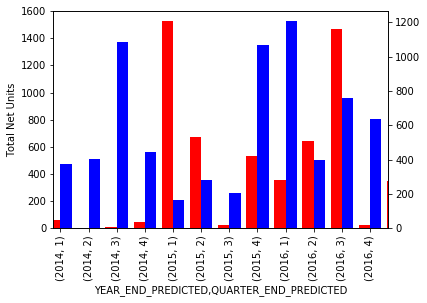

In [311]:
model = train(MLPClassifier(hidden_layer_sizes=(20), random_state=1))
#print('Coefficients: \n', model.coef_)
validate(model)

Prediction for not completed buildings:


,PERMIT_ID,NAMEADDR,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,DURATION_PREDICTED,YEAR_END,QUARTER_END,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,COST,QUARTERS_LEFT
0,N201305015894,181 FREMONT ST,140,140,2013,4,14,7,2017,1,2015,4,136313594,-7
2,N201305036062,555 FULTON ST,139,139,2014,1,13,7,2017,1,2016,1,48723500,-6
4,N201402047761,2800 SLOAT BL,56,56,2014,4,10,7,2017,1,2016,4,30000000,-3
5,N200602023710,570 JESSIE ST,47,47,2015,1,9,3,2017,1,2016,1,7000000,-6
6,N200810315636,1490 OCEAN AV,15,15,2015,1,9,6,2017,1,2016,4,3000000,-3
7,N200910209343,202 BROAD ST,2,2,2014,3,11,7,2017,1,2016,3,700000,-4
8,N200910209344,200 BROAD ST,2,2,2014,3,11,7,2017,1,2016,3,750000,-4
11,N201210041365,1880 GOLDEN GATE AV,3,2,2014,4,10,7,2017,1,2016,4,720000,-3
12,N201304164662,272 CLARA ST,3,2,2015,1,9,6,2017,1,2016,4,547311,-3
13,N201403271860,3527 18TH ST,10,2,2015,1,9,6,2017,1,2016,4,110000,-3


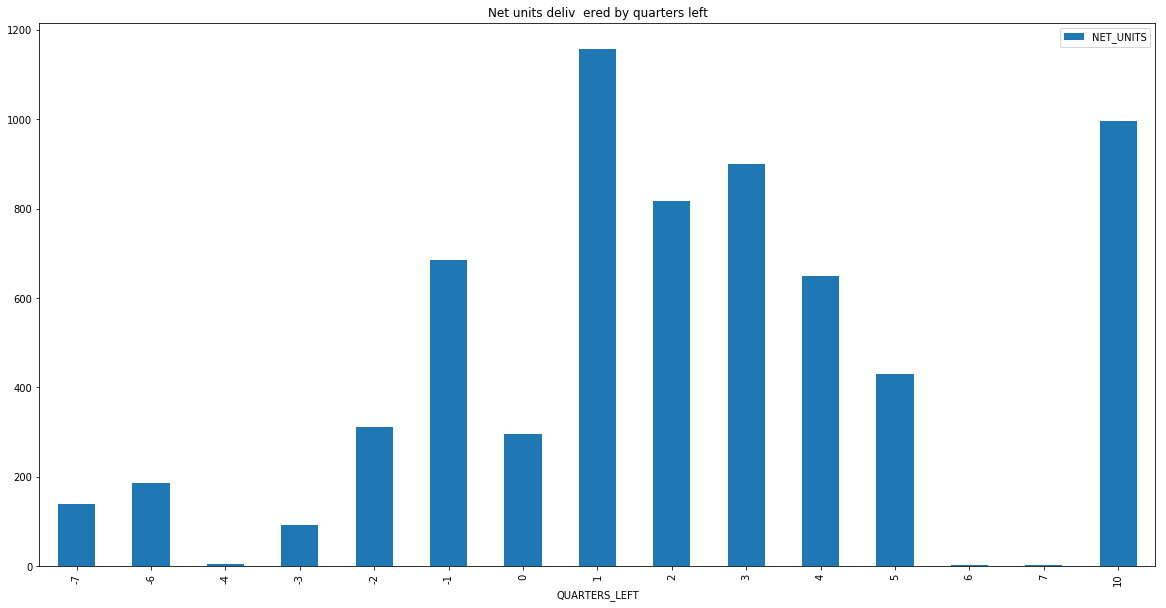

In [312]:
prediction = predict_with_model(model)

In [313]:
columns_to_show = ['PERMIT_ID', 'NAMEADDR_', 'UNITS', 'NET_UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION_PREDICTED', 
                   'YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED', 'COST']

duration_predicted = model.predict(permits[train_columns])
permits['DURATION_PREDICTED'] = np.ceil(duration_predicted).astype('int64')
permits['YEAR_END_PREDICTED'] = np.floor(permits['PERMIT_DATE_YEAR'] + 
                                         (permits['PERMIT_DATE_QUARTER'] + permits['DURATION_PREDICTED']) / 4
                                        ).astype('int64')
permits['QUARTER_END_PREDICTED'] = ((permits['PERMIT_DATE_QUARTER'] + permits['DURATION_PREDICTED']) % 4 + 1).astype('int64')
permits = permits[columns_to_show]
permits.to_csv("data_complete/issued_predictions.csv")
permits = permits.sort_values(['YEAR_END_PREDICTED', 'NET_UNITS'], ascending=[True, False]).drop_duplicates(subset=['PERMIT_ID'], keep="first")
display(permits.head(30))
permits.to_csv("data_complete/issued_predictions.csv")

,PERMIT_ID,NAMEADDR_,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION_PREDICTED,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,COST
1251,N200309154738,Potrero Ave 480,55,55,2004,3,35,2013,3,8000000
38060,N9913300S,Fremont St 321,51,51,2004,2,35,2013,2,11000000
12837,N200602215057,Van Ness Ave 1868,35,35,2008,4,19,2013,4,10000000
154,N200201106632,Corbett Ave 950,3,3,2004,2,35,2013,2,900000
3867,N200404191654,Dolores St 261,3,3,2007,4,21,2013,2,913820
414,N200212062942,24th St 2130,2,2,2004,1,35,2013,1,350000
1103,N200308142054,19th St 1637,2,2,2004,3,35,2013,3,600000
10352,N200507218277,06th Ave 274,3,2,2007,4,21,2013,2,800000
12224,N200512281113,16th Ave 227,2,2,2007,4,21,2013,2,839040
18900,N200705252312,Yukon St 180,2,2,2007,4,21,2013,2,800000


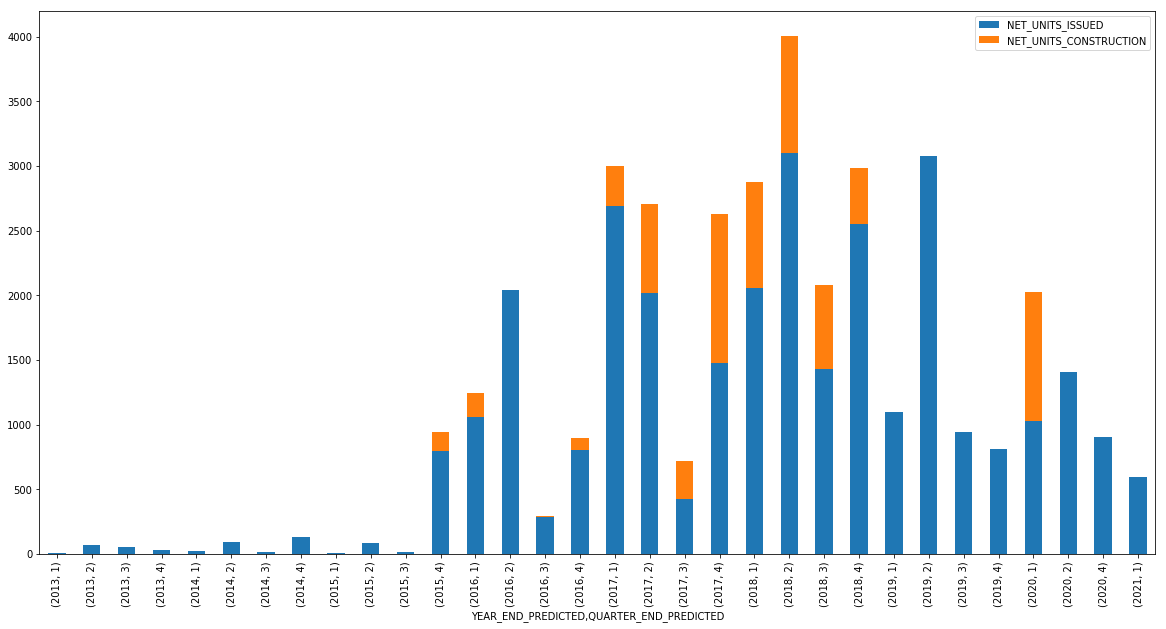

In [314]:
def plot_quarters(df):
    df.plot.bar(stacked=True, figsize=(20,10));

issued_sum = permits.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].sum().reset_index()
construction_sum = prediction.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].sum().reset_index()

df_sum = pd.merge(issued_sum, construction_sum, how='outer', on=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'], 
                  left_on=None, right_on=None, suffixes=('_ISSUED', '_CONSTRUCTION'))

plot_quarters(df_sum.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED']).sum())

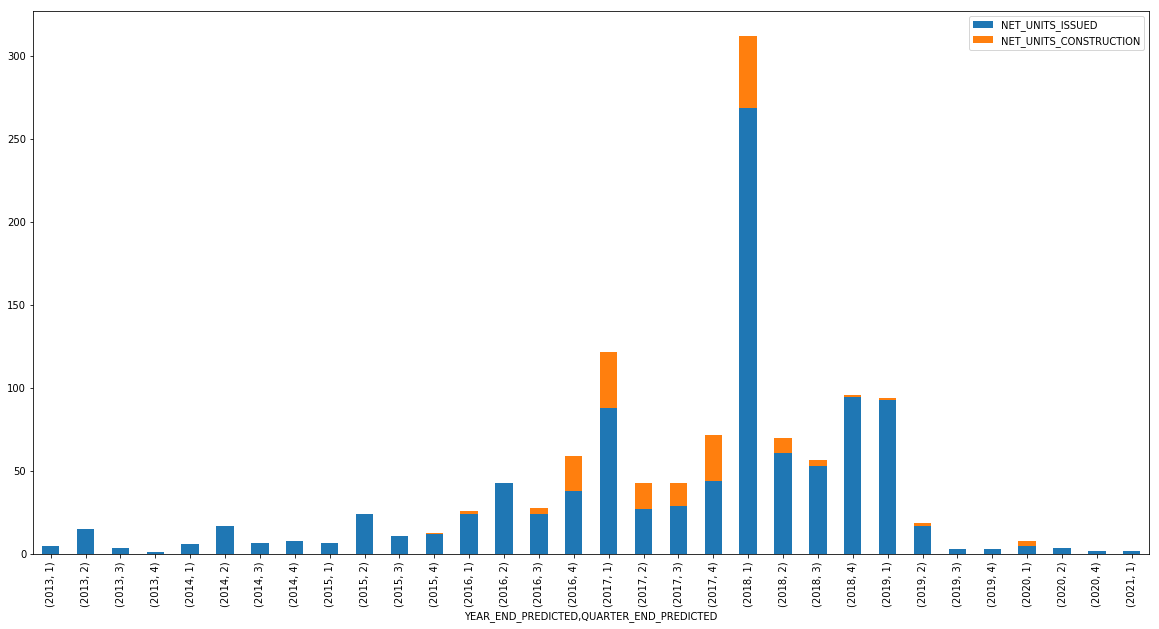

In [315]:
issued_count = permits.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].count().reset_index()
construction_count = prediction.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].count().reset_index()

df_count = pd.merge(issued_count, construction_count, how='outer', on=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'], 
                  left_on=None, right_on=None, suffixes=('_ISSUED', '_CONSTRUCTION'))

plot_quarters(df_count.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED']).sum())

In [275]:
# with linear regression

#model = train(linear_model.LinearRegression(fit_intercept=True, normalize=False))
#print('Coefficients: \n', model.coef_)
#validate(model)

In [274]:
#predict_with_model(model)